<a href="https://colab.research.google.com/github/Nishant-Ramakuru/Inference-based-GNNS/blob/main/simulations/models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import Functions

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import torch
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mcolors
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import random
from torch.utils.data import Dataset
import argparse, os, time
from torch.nn import init
import math
import networkx as nx
import pandas as pd
import os 

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [28]:
import sys
sys.path.append('/content/drive/MyDrive/GNNs')
from utils_functions import *
from models import SingleRNNBaseline

Dataset

In [3]:
df = pd.read_pickle("/content/drive/MyDrive/GNNs/boids_buffer_10_15k.csv")

In [4]:
df.shape

(15000, 4)

In [5]:
df.head()

,R,theta,velocity,trajectory
0,"[[707.02014, 803.3247], [872.8785, 992.9619], ...","[4.3974066, 5.3883123, 1.890375, 5.7133555, 3....","[[-2.0450733, -4.497138], [3.1280887, -3.90064...","[[707.02014, 803.3247, -2.0450733, -4.497138],..."
1,"[[705.57416, 798.53864], [876.0066, 989.0613],...","[4.4348707, 5.3883123, 0.7724528, 5.7133555, 3...","[[-1.446004, -4.786043], [3.1280887, -3.900648...","[[705.57416, 798.53864, -1.446004, -4.786043],..."
2,"[[704.2475, 793.71796], [879.1347, 985.16064],...","[4.4514513, 5.3883123, 0.743052, 5.7133555, 3....","[[-1.3266804, -4.8207207], [3.1280887, -3.9006...","[[704.2475, 793.71796, -1.3266804, -4.8207207]..."
3,"[[702.98267, 788.88055], [882.26276, 981.25995...","[4.461328, 5.3883123, 0.7353079, 5.7133555, 3....","[[-1.2648168, -4.8373585], [3.1280887, -3.9006...","[[702.98267, 788.88055, -1.2648168, -4.8373585..."
4,"[[701.7574, 784.033], [885.39087, 977.3593], [...","[4.468065, 5.3883123, 0.7278318, 5.7133555, 3....","[[-1.2252507, -4.8475423], [3.1280887, -3.9006...","[[701.7574, 784.033, -1.2252507, -4.8475423], ..."


Parameters

In [6]:
params = {}
tau = 1
params['use_adam'] = True
params['test_burn_in_steps'] =40
params['num_time_steps'] = 50
params['data_path']= '/content/MyDrive/GNNs'
params['num_train'] = 10000
params['num_val'] = 2500
params['num_test']= 2500
params['load_model'] = False
params['load_best_model'] = False
params['model_type'] = 'RNN'
#params['graph_type'] = ['static', 'dynamic']
params['graph_type'] = 'dynamic'
params['encoder_no_factor'] = True
params['num_epochs'] = 100
params['num_vars'] = params['num_agents'] = 10
params['input_noise_type'] = 'none'
params['input_size'] = 4
params['nll_loss_type'] = 'gaussian'
params['prior_variance'] = 5e-5
params['batch_size'] = 64
params['val_batch_size'] = 64
params['accumulate_steps'] = 40
params['num_edge_types'] = 1
params['encoder_dropout'] = 0.0
params['encoder_hidden'] = 256
params['encoder_rnn_hidden'] = 64
params['encoder_rnn_type'] = 'lstm'
params['decoder_rnn_type'] = 'lstm'
params['encoder_mlp_num_layers'] = 1
params['encoder_mlp_hidden'] = 256
params['prior_num_layers'] = 1
params['prior_hidden_size'] = 256
params['gpu'] = False
params['decoder_hidden'] = 256
params['skip_first'] = False
params['decoder_dropout'] = 0.0
params['decoder_type'] = None
params['lr'] = 5e-4
params['mode'] = "train"

params['working_dir'] =params['output_dir'] =  ('/content/MyDrive/GNNs')

In [7]:
agent = 9

50


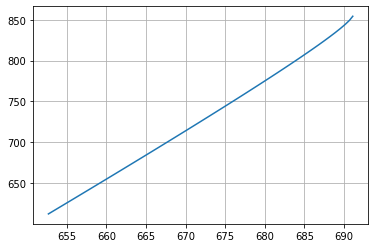

In [8]:
x = []
y = []

for i in range(50):
  x.append(df.trajectory[i][agent][0])
  y.append(df.trajectory[i][agent][1])

%matplotlib inline
print(len(x))
plt.plot(x,y)
plt.grid()
plt.show()

In [9]:
data = []
for w in range(len(df)):
  
  state = np.array(df.R[w])
  D = list()
  for a,i in enumerate(state):
    d= []
    for b,j in enumerate(state):
      eDistance = math.hypot(i[0] - j[0], i[1] - j[1])
      if a == b:
        d.append(0)
      elif int(eDistance) <= 200:
        d.append(1)
      else:
        d.append(0)
    D.append(d)

  data.append(np.array(D))
edge_data = np.array(data)
#all_data = np.array(list(df.trajectory.transpose()))
all_data = df.trajectory.to_numpy()

adj_array = []
#print(edge_data.shape)
for time_step in range(len(edge_data)):
  edge = []
  for i in range(len(edge_data[0])):
    edge = edge + list(list(edge_data[time_step][i][:i])+list(edge_data[time_step][i][i+1:]))
    
  #print(len(edge[0].shape))
  adj_array.append(edge)

edge_data = np.array(adj_array)

50


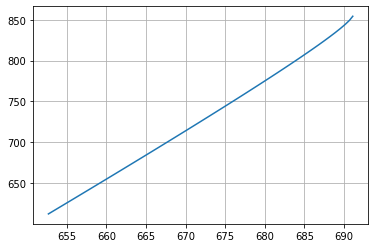

In [10]:
x = []
y = []
for i in range(50):
  x.append(all_data[i][agent][0])
  y.append(all_data[i][agent][1])

%matplotlib inline
print(len(x))
plt.plot(x,y)
plt.grid()
plt.show()

In [11]:
all_data = np.stack(all_data)
train_data = torch.FloatTensor(all_data[:params['num_train']])
val_data = torch.FloatTensor(all_data[params['num_train']:params['num_train']+params['num_val']])
test_data = torch.FloatTensor(all_data[params['num_train']+params['num_val']:params['num_train']+params['num_val']+params['num_test']])

train_edges = torch.FloatTensor(edge_data[:params['num_train']])
val_edges = torch.FloatTensor(edge_data[params['num_train']:params['num_train']+params['num_val']])
test_edges = torch.FloatTensor(edge_data[params['num_train']+params['num_val']:params['num_train']+params['num_val']+params['num_test']])

In [12]:
del all_data, df,edge_data, data

In [13]:
print("Train Shape:", train_data.shape,"\n", 
       "Val Shape:", val_data.shape,"\n",
      "Test Shape:", test_data.shape)

Train Shape: torch.Size([10000, 10, 4]) 
 Val Shape: torch.Size([2500, 10, 4]) 
 Test Shape: torch.Size([2500, 10, 4])


50


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: ignored

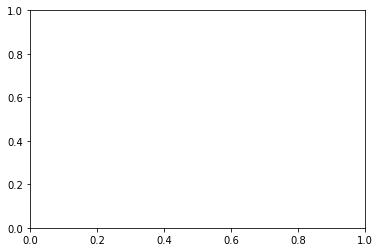

In [17]:
x = []
y = []
for time_step in range(50):
  x.append(train_data[time_step][agent][0])
  y.append(train_data[time_step][agent][1])

%matplotlib inline
print(len(x))
plt.plot(x,y)
plt.grid()
plt.show()

In [15]:
train_data = train_data.reshape([int(params["num_train"]/50),50,10,4])
val_data = val_data.reshape([int(params["num_val"]/50),50,10,4])
test_data = test_data.reshape([int(params["num_test"]/50),50,10,4])

train_edges = train_edges.reshape([int(params['num_train']/50),50,90])
val_edges = val_edges.reshape([int(params['num_val']/50),50,90])
test_edges = test_edges.reshape([int(params['num_test']/50),50,90])

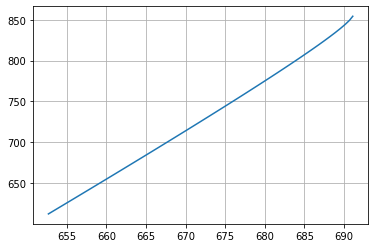

In [16]:
x = []
y = []
for time_step in range(50):
  x.append(train_data[0][time_step][agent][0])
  y.append(train_data[0][time_step][agent][1])

%matplotlib inline
plt.plot(x,y)
plt.grid()
plt.show()

In [18]:
train_data = torch.nn.functional.normalize(train_data)
val_data = torch.nn.functional.normalize(val_data)
test_data = torch.nn.functional.normalize(test_data)

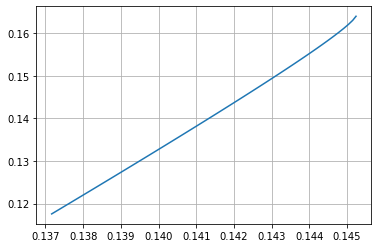

In [19]:
x = []
y = []
for time_step in range(50):
  x.append(train_data[0][time_step][agent][0])
  y.append(train_data[0][time_step][agent][1])
%matplotlib inline
plt.plot(x,y)
plt.grid()
plt.show()

In [20]:
DATA = []

for i in range(train_data.shape[0]):
  DATA.append({'inputs':train_data[i].reshape([1,50,10,4]),'edges':train_edges[i].reshape([1,50,90])})

VAL = []

for i in range(val_data.shape[0]):
  VAL.append({'inputs':val_data[i].reshape([1,50,10,4]),'edges':val_edges[i].reshape([1,50,90])})

TEST = []

for i in range(test_data.shape[0]):
  TEST.append({'inputs':test_data[i].reshape([1,50,10,4]),'edges':test_edges[i].reshape([1,50,90])})

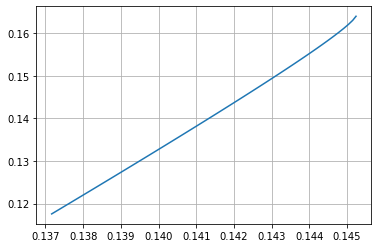

In [21]:
x = []
y = []
for time_step in range(50):
  x.append(DATA[0]['inputs'][0][time_step][a][0])
  y.append(DATA[0]['inputs'][0][time_step][a][1])
%matplotlib inline
plt.plot(x,y)
plt.grid()
plt.show()

Build Model

In [22]:
def build_model(params):
    if params['model_type'] == 'RNN':
        model = SingleRNNBaseline(params)
        print("dNRI MODEL: ",model)
    if params['load_best_model']:
        print("LOADING BEST MODEL")
        path = os.path.join(params['working_dir'], 'best_model')
        model.load(path)
    elif params['load_model']:
        print("LOADING MODEL FROM SPECIFIED PATH")
        model.load(params['load_model'])
    if params['gpu']:
        model.cuda()
    return model

In [24]:
params['mode'] = 'train'
params['num_epochs'] = 10

In [ ]:
model = build_model(params)
if params['mode'] == 'train':
    with build_writers(params['working_dir']) as (train_writer, val_writer):
        result = train(model, DATA, VAL, params, train_writer, val_writer)

dNRI MODEL:  SingleRNNBaseline(
  (rnn): LSTMCell(4, 256)
  (out): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=256, out_features=4, bias=True)
  )
)
EPOCH 1 0
BEST VAL RESULT. SAVING MODEL...
EPOCH 1 EVAL: 
	CURRENT VAL LOSS: 1410883.785156
	BEST VAL LOSS:    1410883.785156
	BEST VAL EPOCH:   1
EPOCH 2 17.48884677886963


In [ ]:
#model.predict(TEST[0])

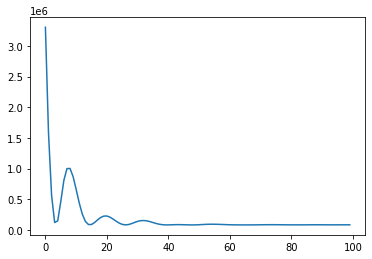

In [ ]:
%matplotlib inline
plt.plot(result)
plt.show()

In [ ]:
model_inputs = TEST[0]['inputs'][:, :40]
model_preds = model.predict_future(model_inputs, 10)
agent = 6
x = []
y = []

for i in range(0,10):
  x.append(float(model_preds[0][i][agent][0]))
  y.append(float(model_preds[0][i][agent][1]))



p = []
q = []

for i in range(0,10):
  p.append(float(TEST[0]['inputs'][:,:-10][0][i][agent][0]))
  q.append(float(TEST[0]['inputs'][:,:-10][0][i][agent][1]))



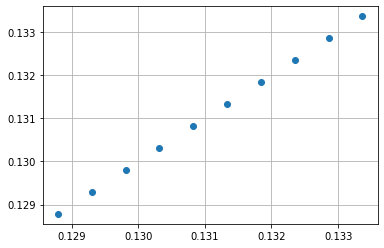

In [ ]:
plt.scatter(p,q)
plt.grid()

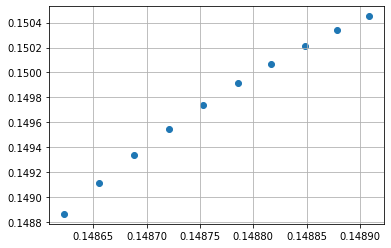

In [ ]:
plt.scatter(x,y)
plt.grid()

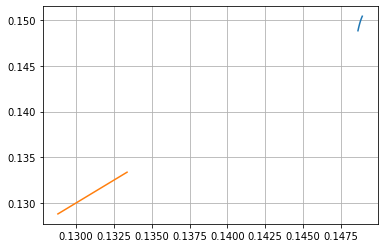

In [ ]:
plt.plot(x,y)
plt.plot(p,q)
plt.grid()

In [ ]:
elif params['mode'] == 'eval':
    test_data = TEST
    forward_pred = 50 - params['test_burn_in_steps']
    test_mse  = eval_forward_prediction(model, test_data, params['test_burn_in_steps'], forward_pred, params)
    #path = os.path.join(params['working_dir'], params['error_out_name']%params['test_burn_in_steps'])
    #np.save(path, test_mse.cpu().numpy())
    test_mse_1 = test_mse[0].item()
    #test_mse_15 = test_mse[14].item()
    test_mse_10 = test_mse[9].item()
    print("FORWARD PRED RESULTS:")
    print("\t1 STEP: ",test_mse_1)
    #print("\t15 STEP: ",test_mse_15)
    print("\t25 STEP: ",test_mse_10)


    f1, all_acc, acc_0, acc_1, edges = eval_edges(model, VAL, params)
    print("Val Edge results:")
    print("\tF1: ",f1)
    print("\tAll predicted edge accuracy: ",all_acc)
    print("\tFirst Edge Acc: ",acc_0)
    print("\tSecond Edge Acc: ",acc_1)
    #out_dir = os.path.join(params['working_dir'], 'preds')
    #os.makedirs(out_dir, exist_ok=True)
    #out_path = os.path.join(out_dir, 'encoder_edges.npy')
    #np.save(out_path, edges.numpy())

    plot_sample(model, test_data, params['test_burn_in_steps'], params)

elif params['mode'] == 'record_predictions':
    model.eval()
    burn_in = params['test_burn_in_steps']
    forward_pred = 50 - params['test_burn_in_steps']
    test_data = TEST
    if params['subject_ind'] == -1:
        val_data_loader = DataLoader(test_data, batch_size=params['batch_size'])
        all_predictions = []
        all_edges = []
        for batch_ind,batch in enumerate(val_data_loader):
            print("BATCH %d of %d"%(batch_ind+1, len(val_data_loader)))
            inputs = batch['inputs']
            if params['gpu']:
                inputs = inputs.cuda(non_blocking=True)
            with torch.no_grad():
                predictions, edges = model.predict_future(inputs[:, :burn_in], forward_pred, return_edges=True, return_everything=True)
                all_predictions.append(predictions)
                all_edges.append(edges)
        if params['error_suffix'] is not None:
            out_path = os.path.join(params['working_dir'], 'preds/', 'all_test_subjects_%s.npy'%params['error_suffix'])
        else:
            out_path = os.path.join(params['working_dir'], 'preds/', 'all_test_subjects.npy')

        predictions = torch.cat(all_predictions, dim=0)
        edges = torch.cat(all_edges, dim=0)

    else:
        data = test_data[params['subject_ind']]
        inputs = data['inputs'].unsqueeze(0)
        if params['gpu']:
            inputs = inputs.cuda(non_blocking=True)
        with torch.no_grad():
            predictions, edges = model.predict_future(inputs[:, :burn_in], forward_pred, return_edges=True, return_everything=True)
            predictions = predictions.squeeze(0)
            edges = edges.squeeze(0)
        out_path = os.path.join(params['working_dir'], 'preds/', 'subject_%d.npy'%args.subject_ind)
    tmp_dir = os.path.join(params['working_dir'], 'preds/')
    if not os.path.exists(tmp_dir):
        os.makedirs(tmp_dir)
    torch.save([predictions.cpu(), edges.cpu()], out_path)
